**Install Requirements**

In [ ]:
# Student ID: 20014176

# MobileNet trained from scratch model on the HAM10000 dataset

!pip install tensorflow==2.2.0
!pip install keras

import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 516.2MB 24kB/s 
     |████████████████████████████████| 460kB 48.2MB/s 
     |████████████████████████████████| 3.0MB 50.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


**Read Dataset**

In [ ]:
# zipped dataset is uploaded to google drive to be accessed by Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset

!unzip "drive/MyDrive/UNUK Year 3 Dissertation/Dataset/Dataset.zip" -d "drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset"

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029326.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029327.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029328.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029329.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029330.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029331.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_images_part_2/ISIC_0029332.jpg  
  inflating: drive/MyDrive/UNUK Year 3 Dissertation/Dataset/Unzippe

**Load Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam
from keras.applications import MobileNet
import cv2
import os

**Read images in dataset**

In [ ]:
# read all files in dataset folder

for dirname, _, filenames in os.walk('drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            print(img.shape)
            break

**More Imports**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,classification_report
import itertools
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import DenseNet169

**Merge Images from Both Folders into One Dictionary**

In [ ]:
base_skin_dir = os.path.join('drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
                     
# label mapping for benign and malignant images

lesion_type_dict = {
    'b': 'benign',
    'm': 'malignant'
}

**Read from CSV File**

In [ ]:
skin_df = pd.read_csv("drive/MyDrive/UNUK Year 3 Dissertation/Dataset/UnzippedDataset/Dataset/HAM10000_metadata.csv")

**change labels for 'dx'**

In [ ]:
# dx is modified to "b" = benign and "m" = malignant

skin_df.loc[skin_df.dx == 'nv', 'dx'] = 'b'
skin_df.loc[skin_df.dx == 'mel', 'dx'] = 'm'
skin_df.loc[skin_df.dx == 'bkl', 'dx'] = 'b'
skin_df.loc[skin_df.dx == 'bcc', 'dx'] = 'm'
skin_df.loc[skin_df.dx == 'akiec', 'dx'] = 'b'
skin_df.loc[skin_df.dx == 'vasc', 'dx'] = 'b'
skin_df.loc[skin_df.dx == 'df', 'dx'] = 'b'

**Create New Columns in CSV**

In [ ]:
# new columns are added to skin_df for better labels

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

**Display Contents of CSV File**

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
1,HAM_0000118,ISIC_0025030,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
2,HAM_0002730,ISIC_0026769,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
3,HAM_0002730,ISIC_0025661,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
4,HAM_0001466,ISIC_0031633,b,histo,75.0,male,ear,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0


In [ ]:
# run this to ensure that both benign and malignant are labelled correctly in the dataset

skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
1,HAM_0000118,ISIC_0025030,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
2,HAM_0002730,ISIC_0026769,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
3,HAM_0002730,ISIC_0025661,b,histo,80.0,male,scalp,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
4,HAM_0001466,ISIC_0031633,b,histo,75.0,male,ear,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,b,histo,40.0,male,abdomen,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
10011,HAM_0002867,ISIC_0033550,b,histo,40.0,male,abdomen,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
10012,HAM_0002867,ISIC_0033536,b,histo,40.0,male,abdomen,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0
10013,HAM_0000239,ISIC_0032854,b,histo,80.0,male,face,drive/MyDrive/UNUK Year 3 Dissertation/Dataset...,benign,0


**See Number of Images for Each Label**

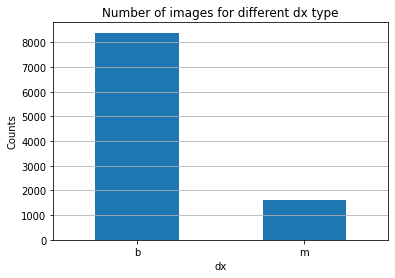

In [ ]:
skin_df['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of images for different dx type')
plt.xlabel('dx')
plt.ylabel('Counts')
plt.grid(axis='y')

**Display Skin Lesion Types Count**

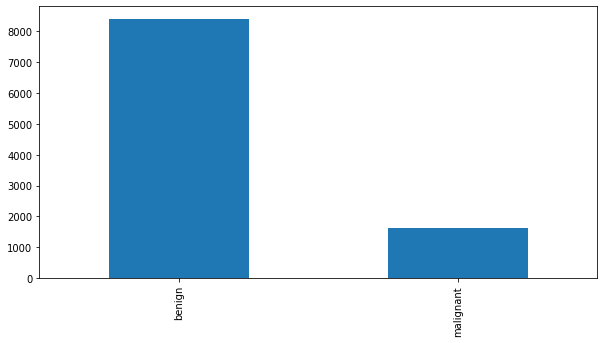

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

**Display Localization of Lesions**

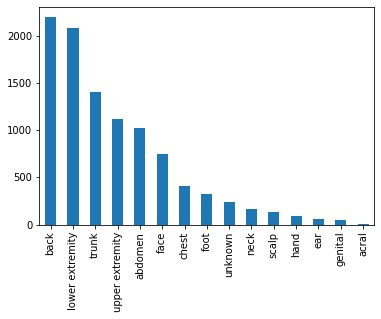

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

**Resize Shape of Images**

In [ ]:
# our CNN accepts inputs of size 150 x 100
# reshape all images in the dataset to standardize

skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128, 128))))

**Check Shape of Images**

In [ ]:
# ensure that all image sizes are correct

skin_df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    10015
Name: image, dtype: int64

**Assign Features and Targets**

In [ ]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

**Train Test Split 1**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**Assign Number of Classes**

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

**Train Test Split 2**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

**Reshape for Input**

In [ ]:
# all 3 sets need to be the same size

x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(128, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(128, 128, 3))

**Assign Input Shape and No of Classes for DenseNet**

In [ ]:
input_shape = (128, 128, 3)
num_classes = 2

**Load DenseNet architecture**

In [ ]:
base_model = DenseNet169(weights="imagenet", include_top=False , input_shape=(128, 128, 3))

51879936/51877672 [==============================] - 0s 0us/step


**Configure Layers in DenseNet**

In [ ]:
from keras.models import Sequential , Model
from keras.layers import Dropout , GlobalAveragePooling2D

x = base_model.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

**Display Model Summary**

In [ ]:
model.summary()
tf.keras.utils.plot_model(model)

Output hidden; open in https://colab.research.google.com to view.

**Load Adam Optimizer**

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

**Compile Model**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Learning Rate Reduction**

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

**Image Data Generator**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

**Model Training and Testing**

In [ ]:
epochs = 10
batch_size = 32


history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction])

Epoch 1/10
225/225 [==============================] - 1850s 8s/step - loss: 0.5812 - accuracy: 0.7699 - val_loss: 0.7913 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/10
225/225 [==============================] - 1807s 8s/step - loss: 0.3643 - accuracy: 0.8360 - val_loss: 0.4101 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 3/10
225/225 [==============================] - 1818s 8s/step - loss: 0.3638 - accuracy: 0.8406 - val_loss: 0.3628 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 4/10
225/225 [==============================] - 1832s 8s/step - loss: 0.3374 - accuracy: 0.8470 - val_loss: 0.5525 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 5/10
225/225 [==============================] - 1793s 8s/step - loss: 0.3213 - accuracy: 0.8518 - val_loss: 3.9038 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 6/10
225/225 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8419
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
225/225 [==============================

**Plot Model's Validation Loss and Validation Accuracy**

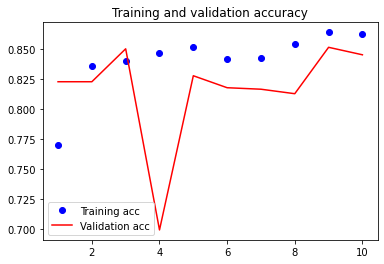

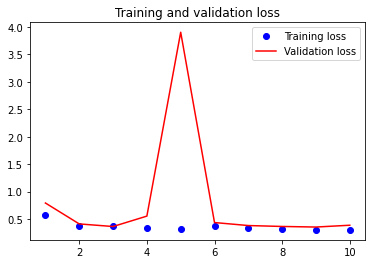

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Display Validation and Test Accuracy**

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 30s 1s/step - loss: 0.3862 - accuracy: 0.8454
Validation: accuracy = 0.845387  ;  loss_v = 0.386176
Test: accuracy = 0.847229  ;  loss = 0.363798


**Function to Plot Confusion Matrix**

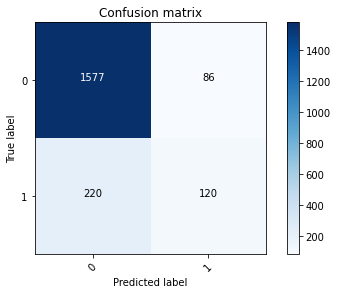

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

**Fraction Classified Incorrectly**

Text(0, 0.5, 'Fraction classified incorrectly')

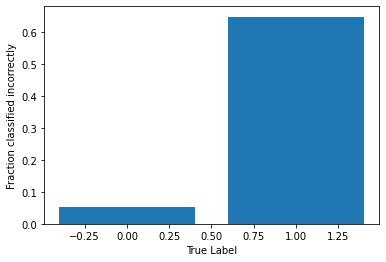

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

**Classification Report**

In [ ]:
labels = ['Benign', 'Malignant']

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

print(classification_report(Y_true, Y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

      Benign       0.88      0.95      0.91      1663
   Malignant       0.58      0.35      0.44       340

    accuracy                           0.85      2003
   macro avg       0.73      0.65      0.68      2003
weighted avg       0.83      0.85      0.83      2003

